# Training a SVM using QEK for Gastrointestinal Polyp Classification  

### Team GIC-quAI

---

## Abstract

This notebook demonstrates the implementation and application of a Quantum Evolution Kernel (QEK) in the training of a Support Vector Machine (SVM) in order to classify between two dataclasses (polyp/no_polyp), using a simulaton of Pasqal's quantum hardware through the Pulser framework.  

The following cells aim to showcase our entire pipeline.  
  
Key components covered include:  

- Data loading and labeling
- Preparation of graph structures 
- Graph to quantum register compilation
- Texture to pulse compilation
- Quantum execution using Pasqal's DigitalAnalogDevice simulator
- Traning and validation of Support Vector Machine models using the Quantum Evolution Kernel
- Visualization of quantum-processed data and classification results

This implementation leverages quantum evolution dynamics to capture complex structural patterns in data, potentially offering advantages over classical graph kernels for specific classification tasks.

## 1. Preliminaries  

First, we need to import the necessary libraries, as well as our custom-made modules

In [ ]:
import os 
import sys 
from pathlib import Path 
import matplotlib.pyplot as plt
import pulser as pl
from pulser import DigitalAnalogDevice, MockDevice, AnalogDevice
from tqdm import tqdm

"""
    Import custom-made modules
"""

# Get the custom-made module directory
current_dir = Path.cwd()
sys.path.append(str(current_dir.parent.parent / "code" / "Pulser_implementation"))

# Backend execution
from qek.data.processed_data import ProcessedData
from qek.backends import QutipBackend
from utils.qek_backend_utils import prepare_for_qek_backend, configure_backend_for_stability

# Pipeline components
from pipeline.data_loader import load_datasets, prepare_graphs_for_compilation
from pipeline.graph_compiler import compile_graphs
from pipeline.model_trainer import prepare_dataset, split_dataset, train_qek_svm_model, run_cross_validation
from pipeline.visualize_examples import visualize_example, visualize_processed_data

# Visualization utils
from visualization.visualization import visualize_graph_with_texture

## 2. Parameter Configuration

### Constants
- `N_QUBITS`: The number of qubits used in the quantum simulation. This determines the length of the quantum register (this is an estimate, since this parameter determines the number of segments created by the SLIC algorithm, which roughly translates to the number of atoms).
- `MAX_SAMPLES`: The maximum number of samples to be processed. This limits the dataset size for computational efficiency.
- `REGISTER_DIM`: The dimension of the quantum register. This typically matches the number of qubits.
- `SLIC_COMPACTNESS`: A parameter for the SLIC (Simple Linear Iterative Clustering) algorithm, controlling the compactness of the superpixels.

### Paths
- `DATA_ROOT`: The root directory for the dataset. This path points to the main data folder.
- `NO_POLYP_DIR`: The directory containing images or data samples labeled as "no polyp".
- `POLYP_DIR`: The directory containing images or data samples labeled as "polyp".

### Quantum Backend Settings
- `ODE_NSTEPS`: The number of steps for the ordinary differential equation (ODE) solver in the quantum simulation.
- `ODE_NSTEPS_HIGH`: A higher number of steps for the ODE solver, used for more accurate simulations.
- `MU_HYPERPARAMETER`: A hyperparameter for the quantum evolution kernel, influencing the dynamics of the quantum system.
- `GLOBAL_PULSE_DURATION_COEF`: A coefficient for scaling the duration of the Rydberg global channel pulses.

### Visualization Settings
- `VISUALIZE_EXAMPLES`: A boolean flag indicating whether to visualize examples of the data and results.

### Device
- `DEVICE`: The quantum device or simulator used for the quantum execution. For example, Pasqal's DigitalAnalogDevice.

### Texture Settings
- `TEXTURE_FEATURE`: The texture feature used for classification. Options include 'homogeneity', 'contrast', 'dissimilarity', 'ASM', 'energy', 'correlation', and 'pca'.

### SVM Class Weights
- `CLASS_WEIGHTS`: The weights assigned to each class in the SVM model. This helps handle class imbalance by giving different importance to each class.

In [ ]:
# Constants
N_QUBITS = 10 # Small number of qubits, harder to test classically for more than 10
MAX_SAMPLES = 200 # Small number of samples for MWE
REGISTER_DIM = 10
SLIC_COMPACTNESS = 15

# Paths
DATA_ROOT = os.path.join(Path.cwd().parent.parent, "data", "Pulser_implementation", "dataset")
NO_POLYP_DIR = os.path.join(DATA_ROOT, "no_polyp")
POLYP_DIR = os.path.join(DATA_ROOT, "polyp")

# Quantum backend settings
ODE_NSTEPS = 50000
ODE_NSTEPS_HIGH = 250000
MU_HYPERPARAMETER = 1.2
GLOBAL_PULSE_DURATION_COEF = 1

# Visualization settings
VISUALIZE_EXAMPLES = True

# Device
DEVICE = DigitalAnalogDevice

# Texture settings (homogeneity, contrast, dissimilarity, ASM, energy, correlation, pca)
TEXTURE_FEATURE = 'pca'

# SVM class weights
CLASS_WEIGHTS = {
    0: 1.0, 
    1: 1.0
}

### 3. Data Loading
- Loads images from both polyp and non-polyp directories
- Converts images into graph representations using superpixel segmentation
- Each superpixel becomes a node with texture features
- Labels are assigned (1 for polyp, 0 for non-polyp)


In [4]:

print(f"Loading data from:\n- No polyp: {NO_POLYP_DIR}\n- Polyp: {POLYP_DIR}")
combined_dataset = load_datasets(
    NO_POLYP_DIR, 
    POLYP_DIR,
    MAX_SAMPLES,
    N_QUBITS,
    use_superpixels=True,
    compactness=SLIC_COMPACTNESS
)

Loading data from:
- No polyp: /home/nuno/Desktop/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/no_polyp
- Polyp: /home/nuno/Desktop/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/polyp
Found 20 images in /home/nuno/Desktop/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/polyp


Converting images to graphs: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Successfully created 20 graphs
Found 20 images in /home/nuno/Desktop/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/no_polyp


Converting images to graphs: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

Successfully created 20 graphs

------------- Dataset created -------------

    - No Polyp Graphs: 20
    - Polyp Graphs: 20
    - Total Graphs: 40

-------------------------------------------
    


### 4. Graph Preparation
- Makes graphs compatible with the Pasqal's Digital-Analog Device
- Ensures proper spacing between nodes (atoms)
- Prepares graph structures for quantum compilation

100%|██████████| 40/40 [00:00<00:00, 274.80it/s]


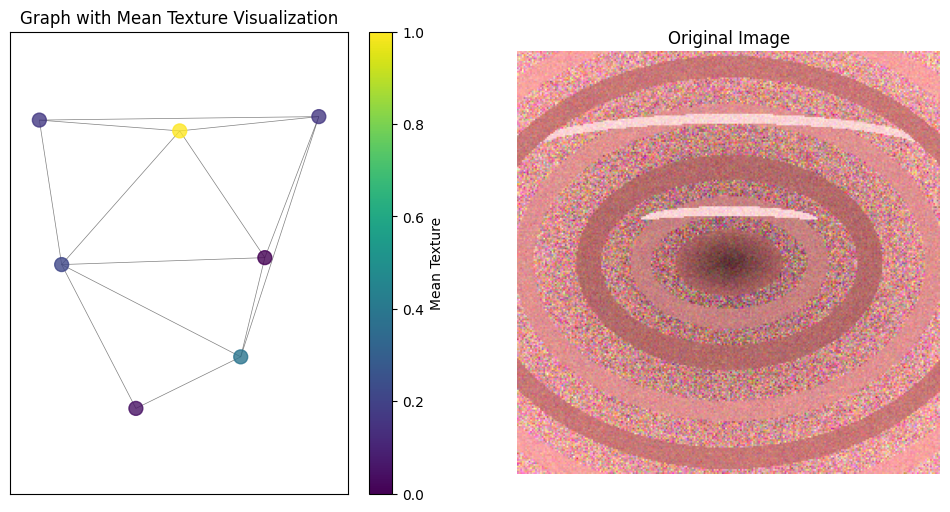

In [5]:
graphs_to_compile, original_data = prepare_graphs_for_compilation(
    combined_dataset,
    device=DEVICE
)

if VISUALIZE_EXAMPLES:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    visualize_graph_with_texture(original_data[0], ax=ax[0])
    
    img_name = combined_dataset[0].filename
    # look for it both in the polyp and no_polyp directories
    if img_name in os.listdir(NO_POLYP_DIR):
        img_dir = os.path.join(DATA_ROOT, 'no_polyp', img_name)
    else:
        img_dir = os.path.join(DATA_ROOT, 'polyp', img_name)

    img = plt.imread(img_dir)
    ax[1].imshow(img)
    ax[1].set_title('Original Image')
    ax[1].axis('off')
    
    plt.show()



### 5. Graph Compilation
- Converts graph representations to quantum registers
- Maps graph nodes to atom positions in the quantum register
- Encodes texture information into the Raman local channel pulses
- Compiles a Rydberg global channel pulse

In [6]:
compiled_graphs = compile_graphs(
    graphs_to_compile,
    original_data,
    register_dim=REGISTER_DIM, 
    texture_feature=TEXTURE_FEATURE,
    global_duration_coef=GLOBAL_PULSE_DURATION_COEF
)


Using device: DigitalAnalogDevice
Register dimension: 10 μm
Minimum atom distance: 4 μm
Available channels: (Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=15.707963267948966, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None), Rydberg(addressing='Local', max_abs_detuning=125.66370614359172, max_amp=62.83185307179586, min_retarget_interval=220, fixed_retarget_t=0, max_targets=1, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None), Raman(addressing='Local', max_abs_detuning=125.66370614359172, max_amp=62.83185307179586, min_retarget_interval=220, fixed_retarget_t=0, max_targets=1, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=None, custom_pha

100%|██████████| 40/40 [00:02<00:00, 15.45it/s]

Compiled 40 graphs out of 40.


### 6. Example Visualization (Optional)
- Visualizes the quantum re\presentation of selected examples
- Shows the mapping between graph structure and quantum register
- Displays pulse sequences designed to encode texture information


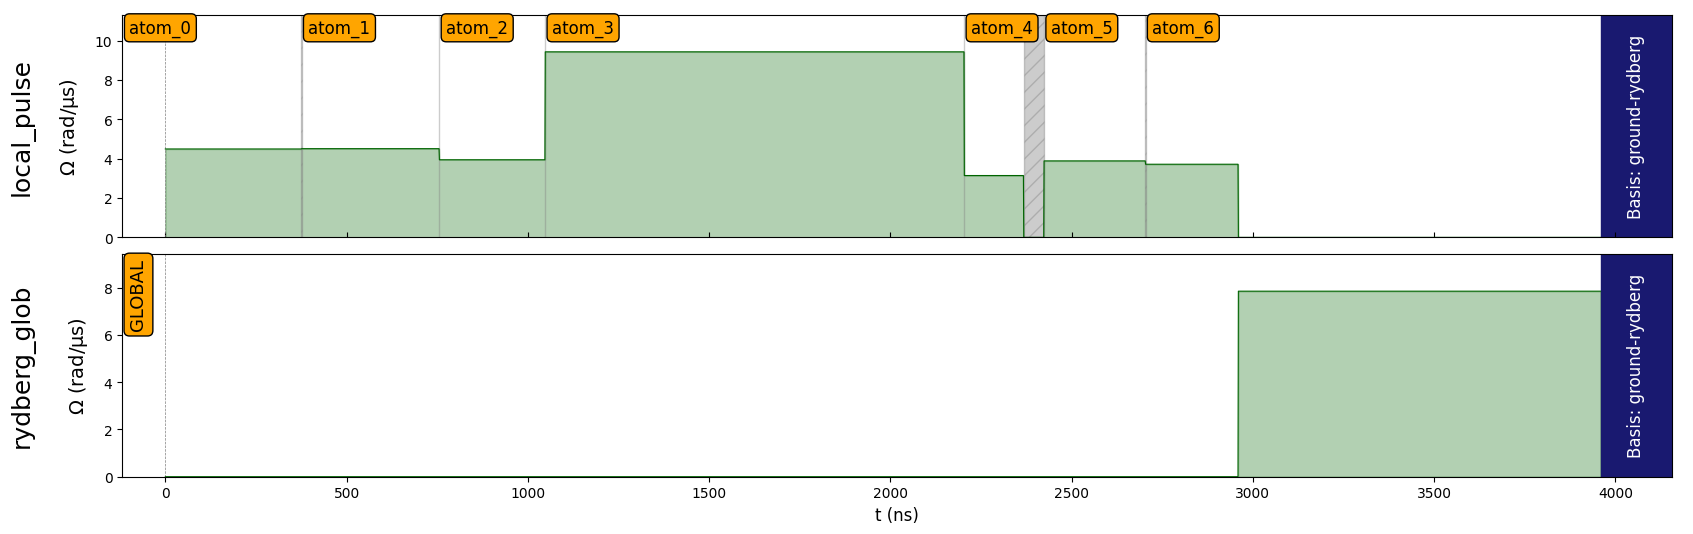

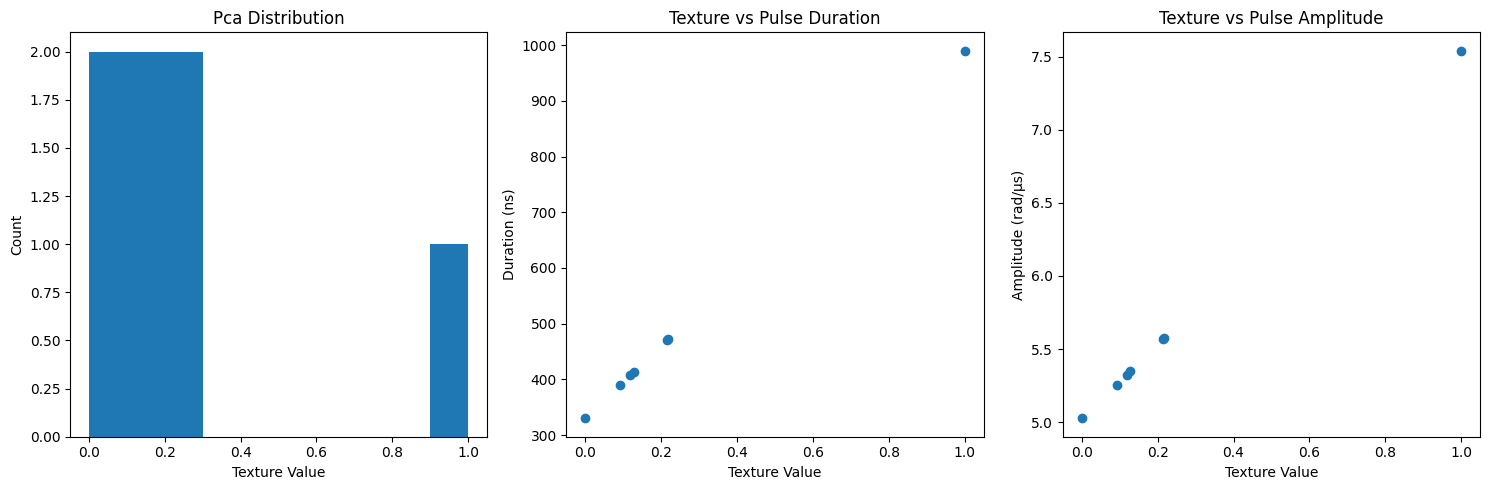

In [7]:
if compiled_graphs and VISUALIZE_EXAMPLES:
    visualize_example(
        compiled_graphs,
        example_index=2
    )
    

### 7. Quantum Execution
- Executes quantum simulations of the compiled graphs
- Uses Pasqal's digital-analog device simulator
- Applies texture-dependent pulses to each atom
- Manages solver parameters to ensure simulation stability
- Captures quantum evolution dynamics that encode graph structure


In [8]:
processed_dataset = []

# Configure backend with optimized solver settings
executor = QutipBackend(device=pl.DigitalAnalogDevice)
executor = configure_backend_for_stability(executor, nsteps=ODE_NSTEPS)

for graph, original_data, sequence in tqdm(compiled_graphs):
    try:
        # Create compatible objects for backend
        register, compatible_pulse = prepare_for_qek_backend(graph, sequence)
        
        try:
            # Run simulation
            states = await executor.run(
                register=register, 
                pulse=compatible_pulse
            )
            
            # Store results
            processed_dataset.append(ProcessedData.from_register(
                register=graph.register,
                pulse=compatible_pulse,
                device=pl.DigitalAnalogDevice,
                state_dict=states,
                target=graph.target
            ))
            
        except Exception as e:
            if "Excess work done" in str(e):
                print(f"ODE solver error with graph {graph.id}, retrying with higher nsteps...")
                # Try with higher nsteps
                temp_executor = configure_backend_for_stability(
                    QutipBackend(device=pl.DigitalAnalogDevice), 
                    nsteps=ODE_NSTEPS_HIGH  
                )
                states = await temp_executor.run(register=register, pulse=compatible_pulse)
                
                processed_dataset.append(ProcessedData.from_register(
                    register=graph.register,
                    pulse=compatible_pulse,
                    device=pl.DigitalAnalogDevice,
                    state_dict=states,
                    target=graph.target
                ))
            else:
                raise e
                
    except Exception as e:
        print(f"Error processing graph {graph.id}: {str(e)}")

100%|██████████| 40/40 [03:19<00:00,  5.00s/it]


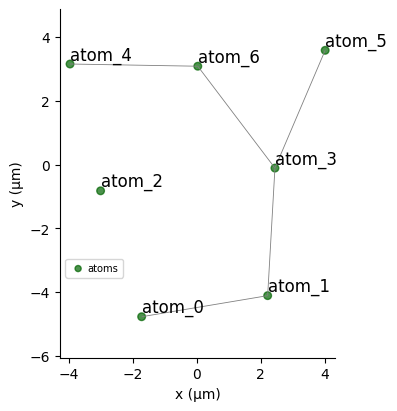

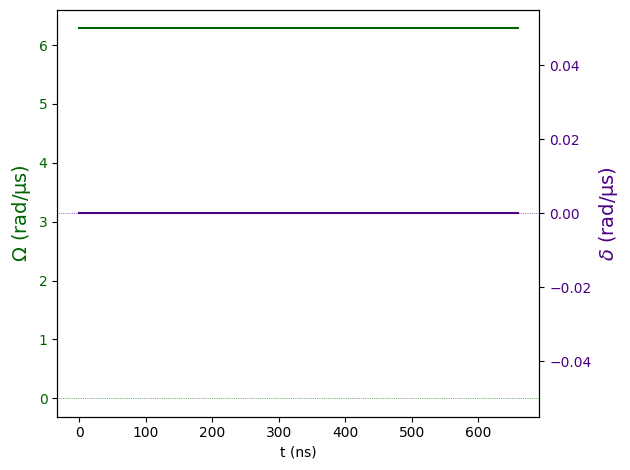

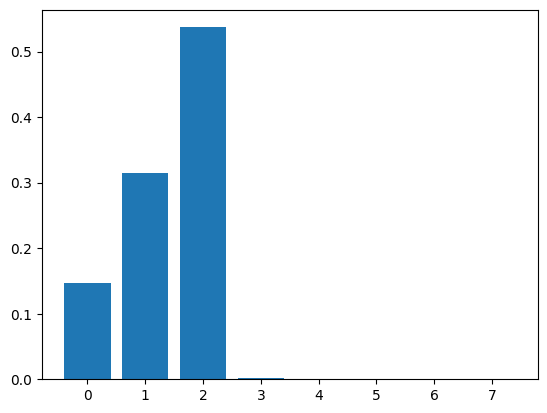

In [9]:
if processed_dataset and VISUALIZE_EXAMPLES:
    visualize_processed_data(processed_dataset)


### 8. Dataset Preparation
- Organizes processed data for machine learning
- Reports class distribution in the processed dataset


In [10]:
X, y = prepare_dataset(processed_dataset)


Class distribution in processed dataset:
No polyp (0): 20
Polyp (1): 20


### 9. Model Training
- Splits data into training and testing sets
- Creates a Support Vector Machine with Quantum Evolution Kernel
- Trains the SVM model on quantum-processed data
- Makes predictions on test data
- Evaluates model performance (F1 score, balanced accuracy, etc.)

### 10. Result Analysis
- Generates detailed classification reports
- Analyzes prediction errors and confidence levels
- Performs cross-validation for robust performance assessment

Size of the training set: 32
Size of the testing set: 8
Class distribution - Training: No polyp: 16, Polyp: 16
Class distribution - Testing: No polyp: 4, Polyp: 4

Training SVM model with Quantum Evolution Kernel...

Model Prediction Analysis:
Unique predicted classes: [0 1]
Number of predictions for each class: [4 4]
True class distribution: [4 4]

Evaluation Results:
F1 Score: 1.0
Balanced Accuracy Score: 1.0

Confusion Matrix:
[[4 0]
 [0 4]]


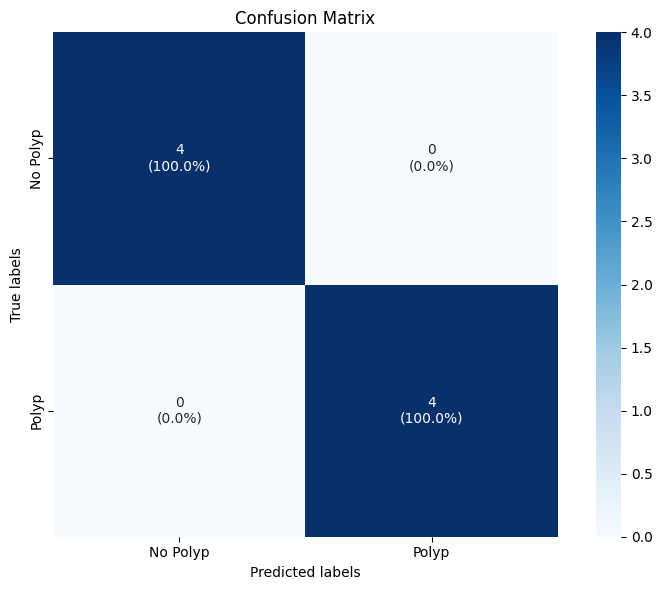


Classification Report:
              precision    recall  f1-score   support

    No Polyp       1.00      1.00      1.00         4
       Polyp       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


=== DETAILED PREDICTION ANALYSIS ===
Correctly detected polyps: 4 of 4
Missed polyps: 0 of 4
False alarms: 0 of 4
=== END ANALYSIS ===


--- End of Model Analysis ---

Running cross-validation to get a more robust assessment:
Cross-validation balanced accuracy: 0.6250 ± 0.0250


array([0.65, 0.6 ])

In [11]:
X_train, X_test, y_train, y_test = split_dataset(X, y)

model, y_pred = train_qek_svm_model(
    X_train,
    X_test,
    y_train,
    y_test,
    mu=MU_HYPERPARAMETER,
    class_weight=CLASS_WEIGHTS
)

run_cross_validation(
    model, 
    X, 
    y
)

In [12]:
print("\nPipeline execution completed.")
print("\nConfig parameters:")
print(f"Number of qubits: {N_QUBITS}")
print(f"Maximum samples: {MAX_SAMPLES}")
print(f"Register dimension: {REGISTER_DIM}")
print(f"Device: {DEVICE}")
print(f"ODE nsteps: {ODE_NSTEPS}")
print(f"ODE nsteps high: {ODE_NSTEPS_HIGH}")
print(f"Texture feature: {TEXTURE_FEATURE}")
print(f"μ hyperparameter: {MU_HYPERPARAMETER}")
print(f"Class weights: {CLASS_WEIGHTS}")
print(f"Compactness: {SLIC_COMPACTNESS}")
print(f"Global pulse duration coef: {GLOBAL_PULSE_DURATION_COEF}")


Pipeline execution completed.

Config parameters:
Number of qubits: 10
Maximum samples: 20
Register dimension: 10
Device: DigitalAnalogDevice
ODE nsteps: 50000
ODE nsteps high: 250000
Texture feature: pca
μ hyperparameter: 1.5
Class weights: {0: 1.0, 1: 1.0}
Compactness: 15
Global pulse duration coef: 1


## Discussion

### Key Findings
- Our Quantum Evolution Kernel enhances gastrointestinal polyp classification by encoding texture information directly into quantum dynamics, leveraging Pasqal's digital-analog architecture.
- The graph-based approach with superpixel segmentation captures important structural and texture features of medical images that relate to polyp presence.
- Texture-aware quantum pulse sequences enable us to encode different features (energy, contrast, homogeneity) into the quantum evolution, providing a physics-inspired approach to feature extraction.
- Quantum Evolution Kernel provides a novel similarity measure between medical images that enhances the performance of classical SVM models.

### Prominent Challenges
- **Quantum Simulation Stability**: ODE solver parameters require careful tuning to ensure convergence for complex quantum evolutions, sometimes requiring significantly higher computational steps.
- **Register Design Constraints**: Positioning quantum atoms while respecting minimum distance requirements presents challenges for representing complex image structures.
- **Texture Encoding Complexity**: Transforming varied texture features into meaningful quantum pulse parameters requires careful feature engineering and normalization.
- **Computational Resources**: Quantum simulations with high ODE step counts (up to 250,000) demand substantial computational resources, limiting **classical** scalability.

### Future Advancements and Scalability
- **Advanced Texture Features**: Exploring combination of different texture features (GLCM, LBP, frequency domain) to improve quantum encoding relevance for polyp detection.
- **Optimized Pulse Design**: Investigating more sophisticated pulse sequences that better capture the subtle differences between polyp and non-polyp regions.
- **Hardware Implementation**: Moving beyond simulation to execute the pipeline on actual Pasqal quantum processors to assess real-world performance.
- **Larger Quantum Registers**: Scaling to higher qubit counts to represent medical images with finer granularity while maintaining quantum advantage.

### Implementation Logistics Considerations
- **Clinical Validation**: Ensuring that quantum-enhanced classifications are thoroughly validated against gold standard medical diagnoses before clinical deployment.
- **Interpretability**: Making quantum-enhanced predictions more interpretable to clinicians, particularly for borderline polyp cases where intervention decisions are critical.
- **Dataset Diversity**: Expanding the dataset to include diverse patient populations and polyp types to ensure equitable performance across demographics.
- **Computational Accessibility**: Developing methods to make quantum approaches more accessible to medical institutions with limited computational resources.

---

This analysis showcases our novel quantum-powered methodology for identifying gastrointestinal polyps, while recognizing existing constraints and presenting compelling avenues for future exploration to further the integration of quantum computing techniques in healthcare imaging diagnostics.

## Conclusion

Our Quantum Evolution Kernel approach demonstrates promising results for gastrointestinal polyp classification. By encoding texture information from medical images into quantum dynamics, we achieve a unique approach to medical image analysis that leverages quantum properties.

### Key Advantages:

1. **Enhanced Feature Representation**: The Quantum Evolution Kernel captures complex structural and texture patterns in medical images that classical methods might miss.

2. **Interpretable Binary Classification**: Our approach provides clear polyp/non-polyp predictions that are essential for clinical screening applications.

3. **Texture-Aware Quantum Encoding**: By encoding texture features directly into quantum pulse sequences, we create a physics-inspired approach to image classification.

4. **Scalable Architecture**: Our pipeline can accommodate different texture features (energy, homogeneity, contrast, PCA) allowing flexibility in feature engineering.

### Future Work:

- Explore more complex quantum register topologies for image representation
- Investigate performance across different texture feature extraction methods
- Validate the model on larger and more diverse polyp datasets
- Benchmark against classical graph kernels to quantify potential quantum advantage
- Explore hardware implementation on actual Pasqal quantum processors

---

### Team GIC-quAI

This work was developed by Team GIC-quAI for the Quantum Machine Learning for Medical Imaging Challenge.